In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import polars as pl
import seaborn as sns
from jax import random
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS, Predictive

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
data_df = pl.read_csv(
    "https://raw.githubusercontent.com/rtdew1/rtdew1.github.io/master/ls_sim.csv",
    dtypes={"id": pl.Categorical},
)

data_df.head()

y,id,fs,t,r,l,pnum
i64,cat,i64,i64,i64,i64,i64
0,"""1""",20,21,1,1,2
0,"""1""",20,22,2,2,2
0,"""1""",20,23,3,3,2
0,"""1""",20,24,4,4,2
0,"""1""",20,25,5,5,2


In [3]:
data_df["id"].unique().shape[0]

7969

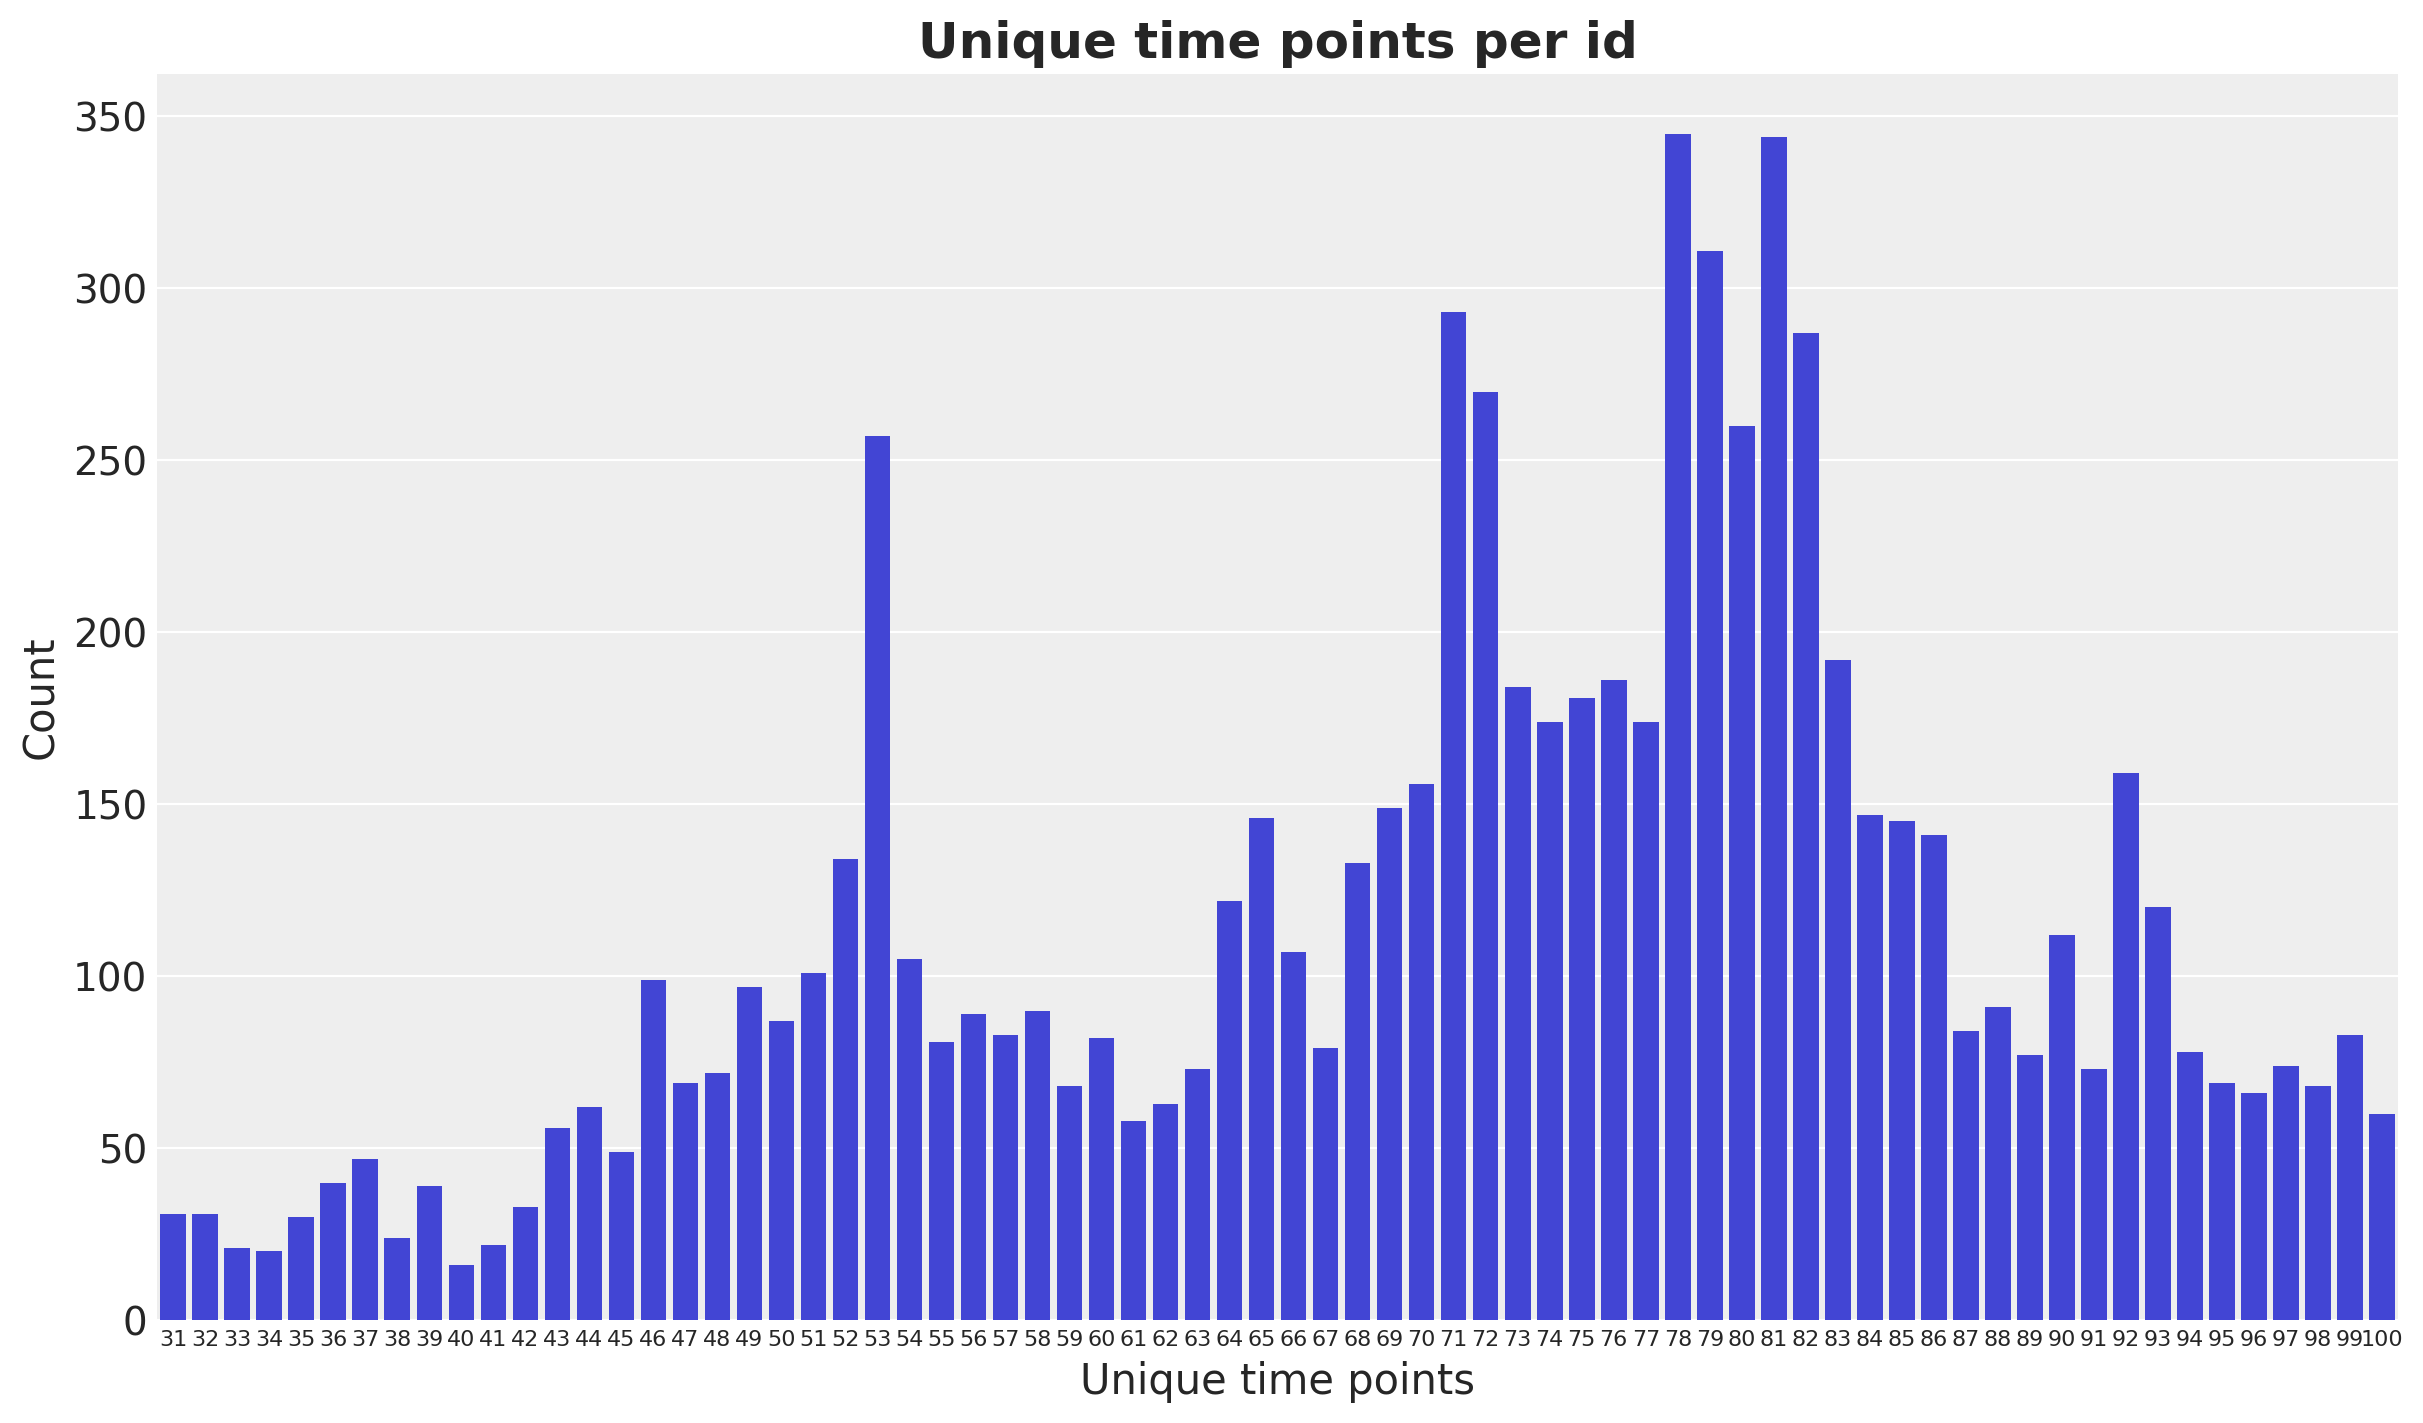

In [4]:
fig, ax = plt.subplots()
(
    data_df.group_by("id")
    .agg(pl.col("t").count().alias("t_unique"))
    .sort("t_unique")
    .group_by("t_unique")
    .agg(pl.col("id").count().alias("count"))
    .pipe(lambda df: sns.barplot(data=df, x="t_unique", y="count", ax=ax))
)
ax.tick_params(axis="x", which="both", labelsize=8)
ax.set(xlabel="Unique time points", ylabel="Count")
ax.set_title("Unique time points per id", fontsize=18, fontweight="bold");

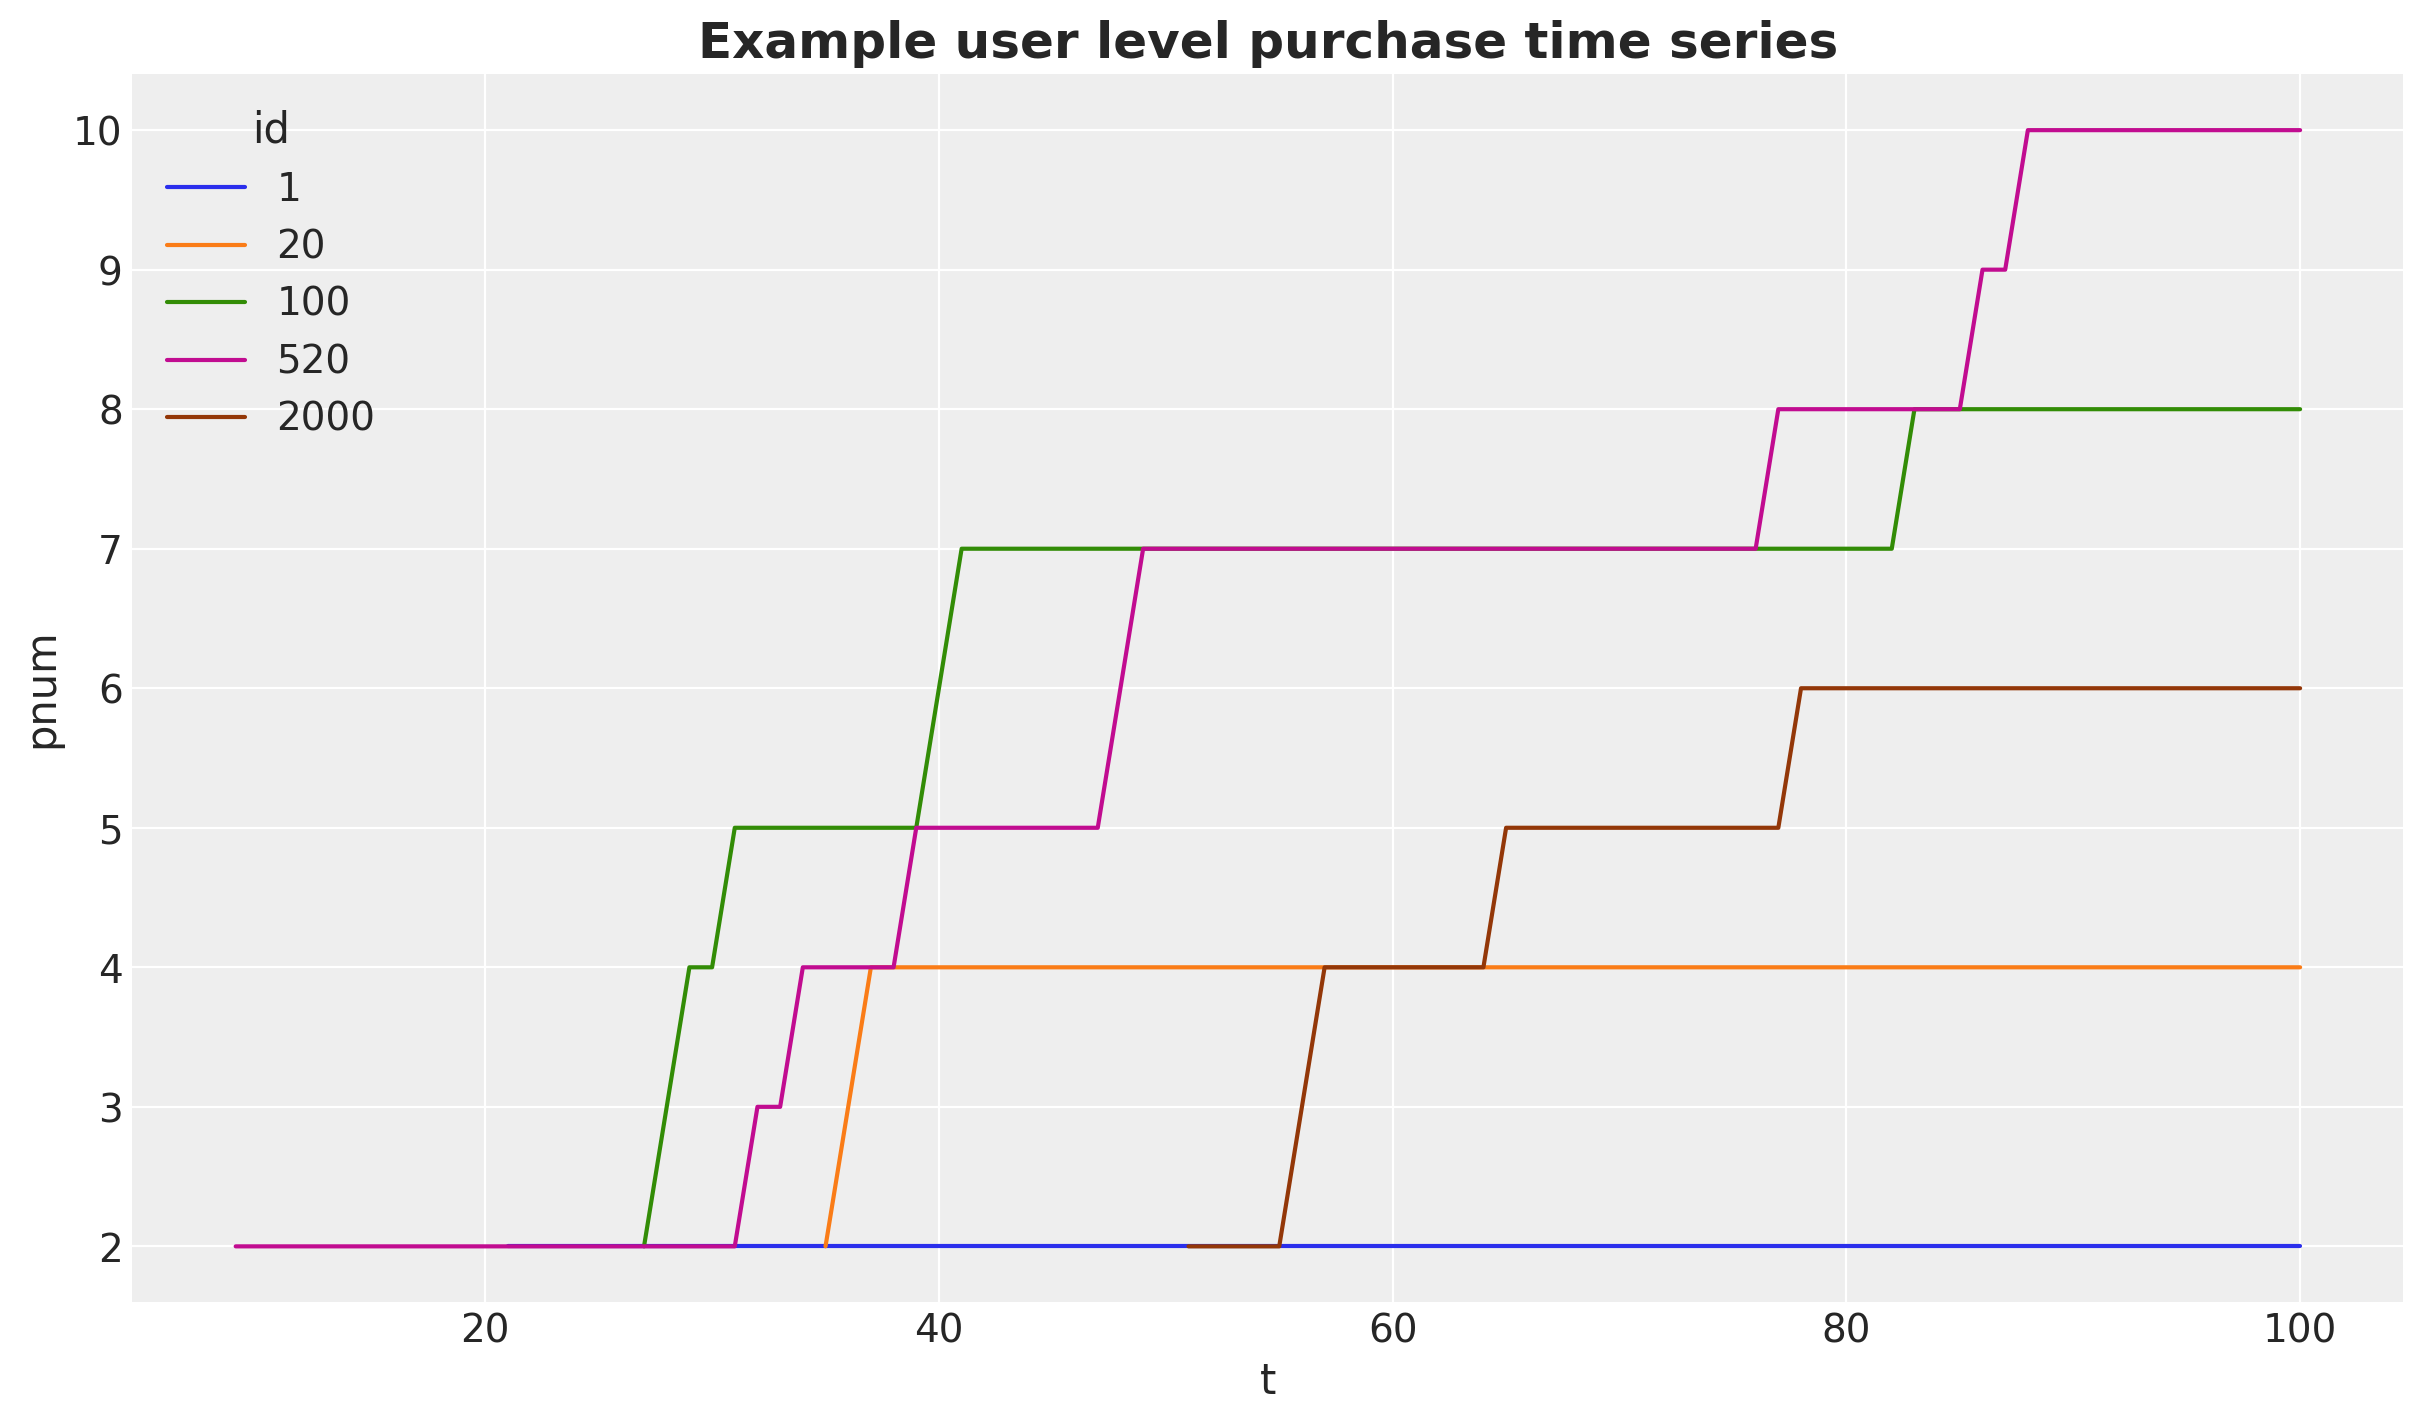

In [5]:
fig, ax = plt.subplots()
for i, idx in enumerate(["1", "20", "100", "520", "2000"]):
    sns.lineplot(
        data=data_df.filter(pl.col("id") == idx),
        x="t",
        y="pnum",
        color=f"C{i}",
        label=idx,
        ax=ax,
    )
ax.legend(title="id", title_fontsize=15, loc="upper left")
ax.set_title("Example user level purchase time series", fontsize=18, fontweight="bold");

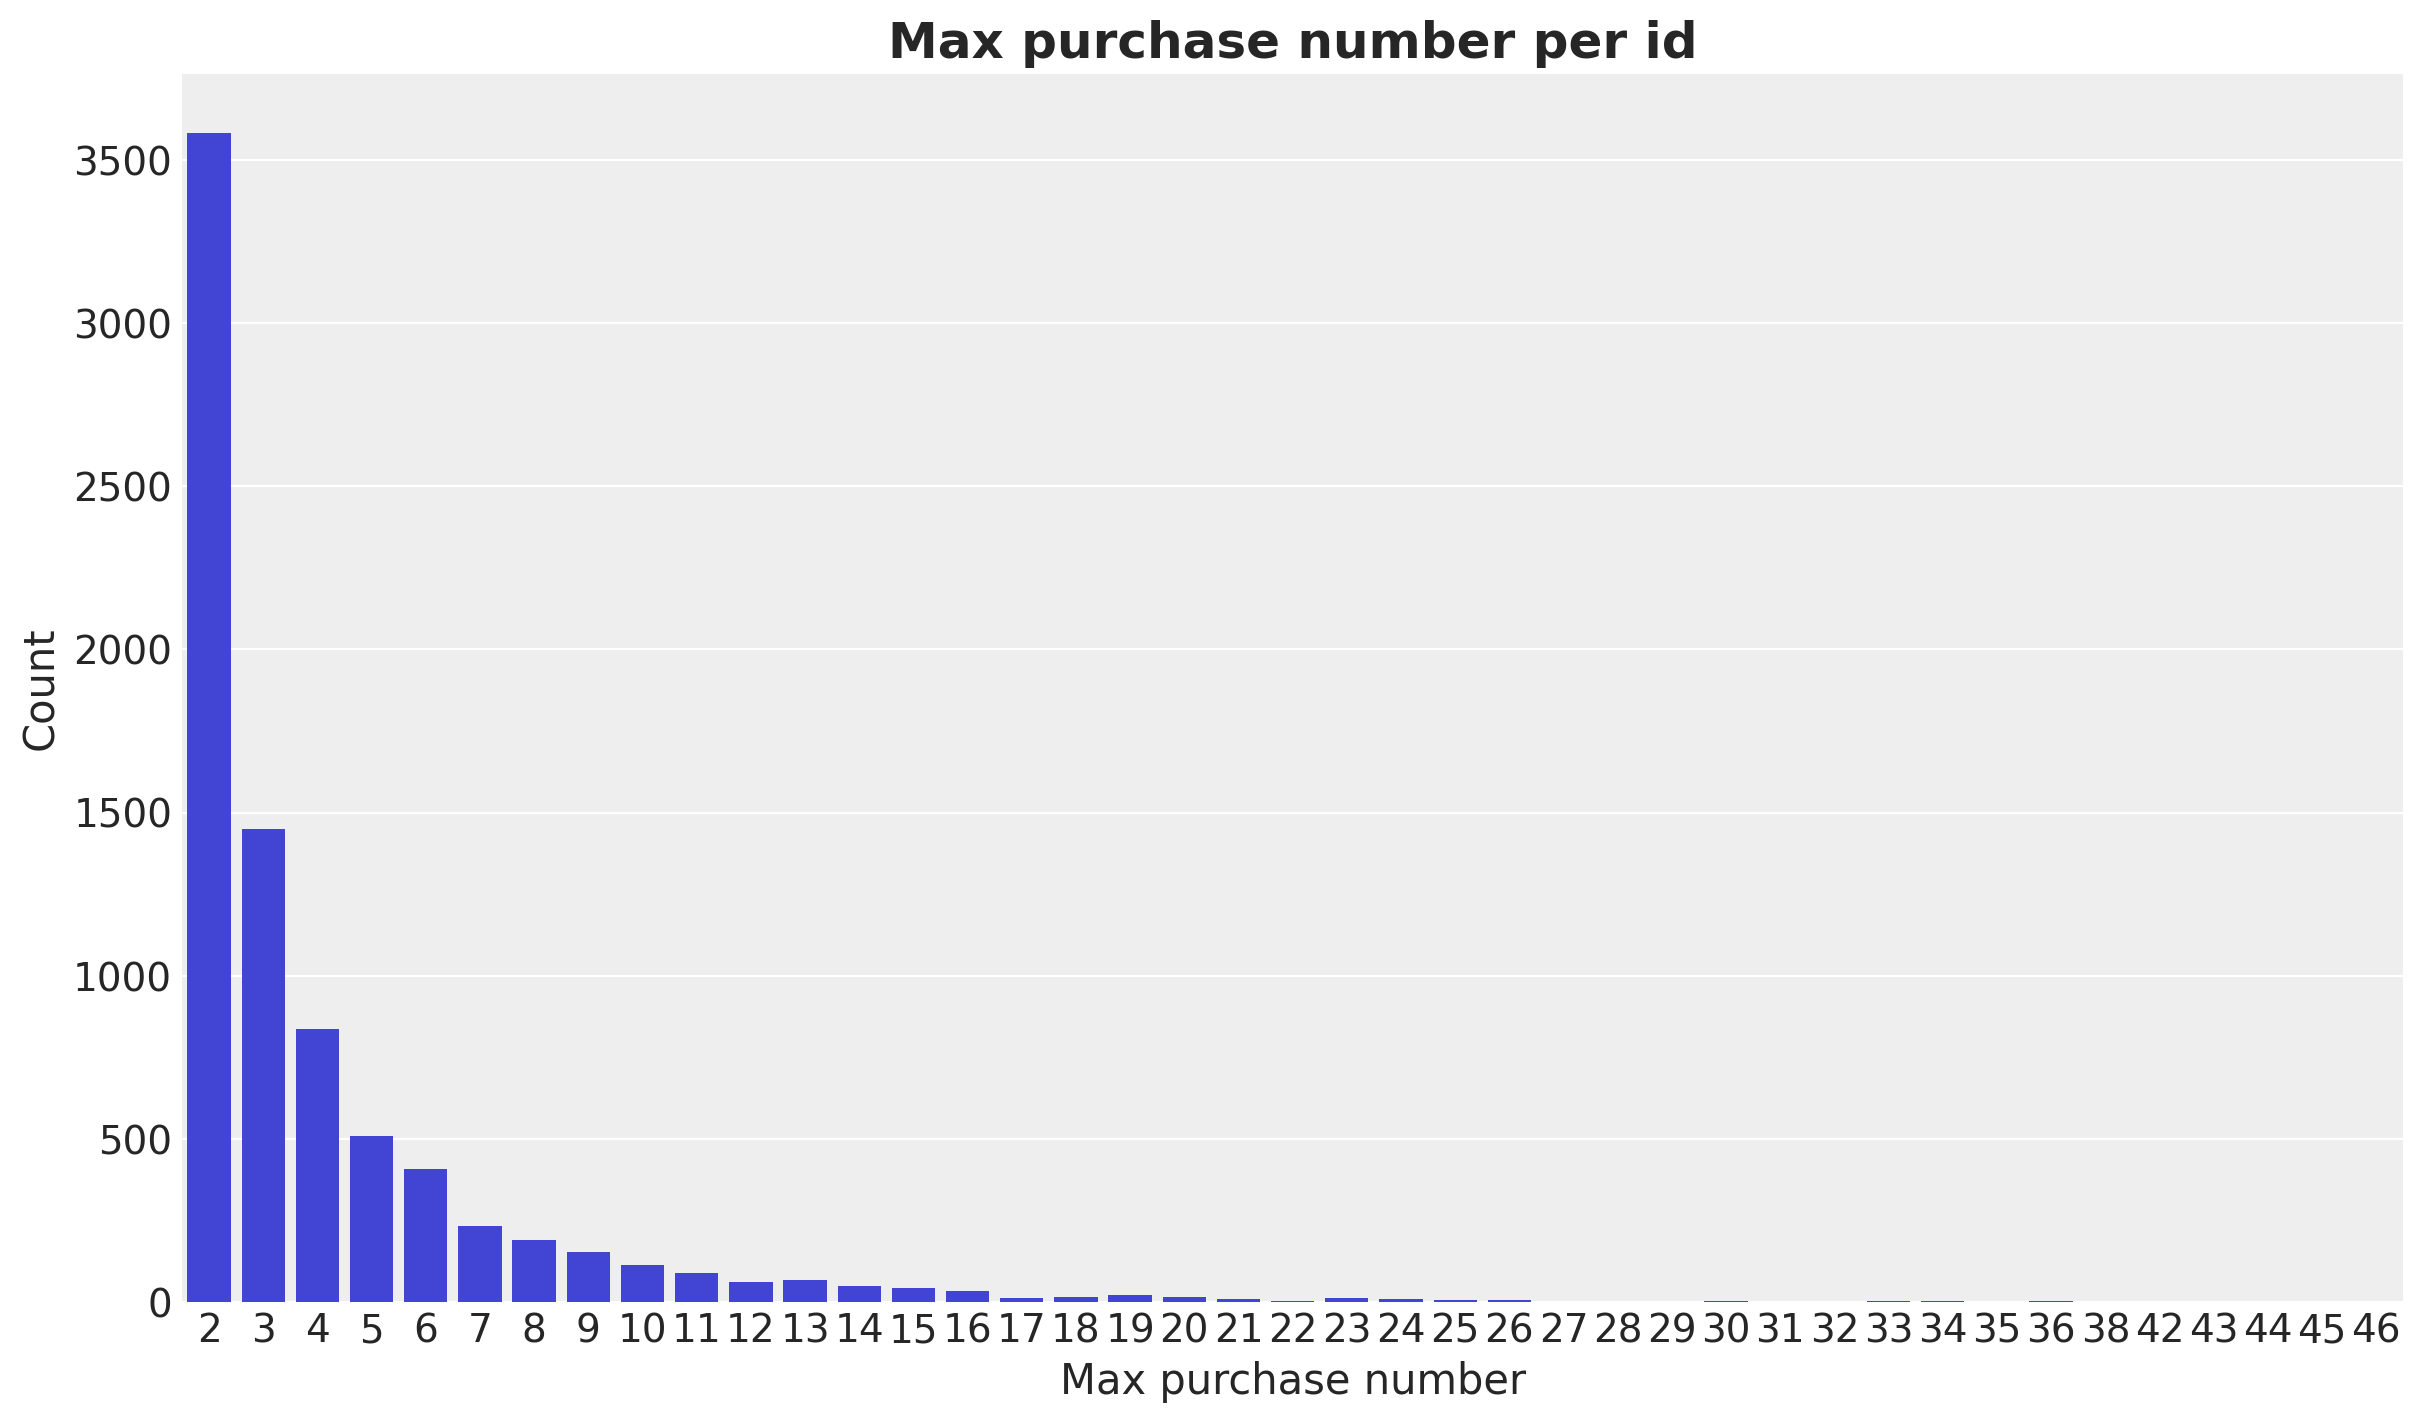

In [6]:
fig, ax = plt.subplots()
(
    data_df.group_by("id")
    .agg(pl.col("pnum").max().alias("max_pnum"))
    .group_by("max_pnum")
    .agg(pl.col("id").count().alias("count"))
    .sort("count")
    .pipe(lambda df: sns.barplot(data=df, x="max_pnum", y="count"))
)
ax.set(xlabel="Max purchase number", ylabel="Count")
ax.set_title("Max purchase number per id", fontsize=18, fontweight="bold");